# Postprocessing

The Isoforce data is recorded using three different channels named:

- **P** $\rightarrow \quad \text{Position}$ `AI0`
- **T** $\rightarrow \quad \text{Torque}$ `AI1`
- **S** $\rightarrow \quad \text{Speed}$ `AI2`

During the postprocessing, the global parameter name is used as follows with the corresponding class.

- **P** $\rightarrow \quad \text{Angle}$ `AI0` $\rightarrow$ `IsoforceIso.angle` colored in red (C3)
- **T** $\rightarrow \quad \text{Torque}$ `AI1` $\rightarrow$ `IsoforceIso.torque` colored in blue (C0)
- **S** $\rightarrow \quad \text{Speed}$ `AI2` $\rightarrow$ `IsoforceIso.speed` colored in yellow (C8)

**Set data path**

In [1]:
path = "data/serious_data/Final_Measurements/P01/"

## Start postprocessing

- `isoforce_iso` contains the data recorded with the Isoforce
- `isoforce_py_raw` contains the Isoforce data recorded with the Python script
- `sciospec_EIT_raw` contains the EIT data recorded with the EIT device

In [2]:
import os
from glob import glob

import matplotlib.pyplot as plt
import numpy as np

from src import (
    IsoforceIso,
    ProcessingDir,
    process_sciospec_eit,
    renderDF,
    scale_to_range,
)

In [3]:
part_path = ProcessingDir(path)

Fund participant data:

Head directory: self.path='data/serious_data/Final_Measurements/P01/'
Raw Isoforce data measured by Isoforce:
	self.isoforce_iso='data/serious_data/Final_Measurements/P01/EIT_P01_raw_data_12012025114030.txt'
Raw Isoforce data measured by Python:
	self.isoforce_py_raw='data/serious_data/Final_Measurements/P01/iso_raw/'
Raw sciospec EIT data:
	self.sciospec_EIT_raw='data/serious_data/Final_Measurements/P01/eit_raw/'
Raw sciospec EIT samples:
	self.EIT_samples_raw='data/serious_data/Final_Measurements/P01/eit_raw/20250218 17.03.01/setup/'
Preprocessed sciospec EIT samples:
	self.s_path_eit='data/serious_data/Final_Measurements/P01/EIT_processed/'


In [4]:
DF = renderDF(part_path.isoforce_iso)

!!!The torque data is lowpass filtered!!!
!!!The angle data is lowpass filtered!!!


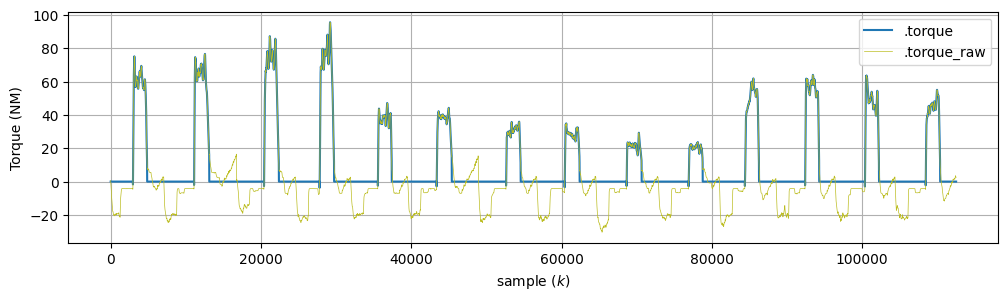

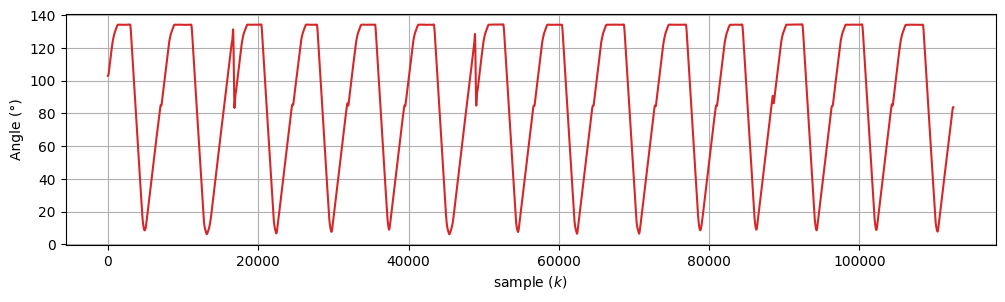

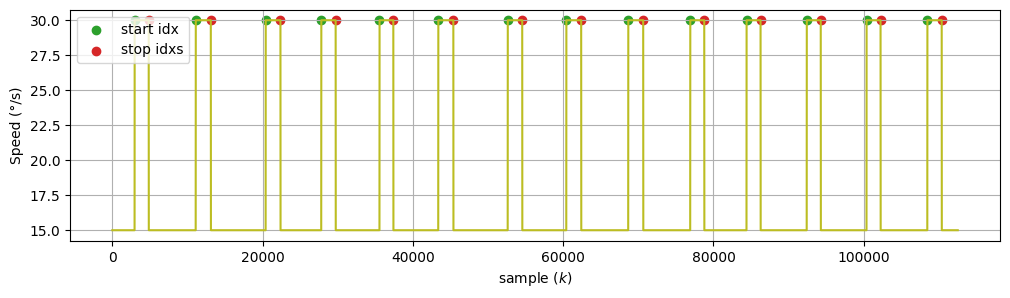

In [5]:
isoforce_iso = IsoforceIso(DF, LP_filter=True)
isoforce_iso.plot_torque()
isoforce_iso.plot_angle()
isoforce_iso.plot_speed()

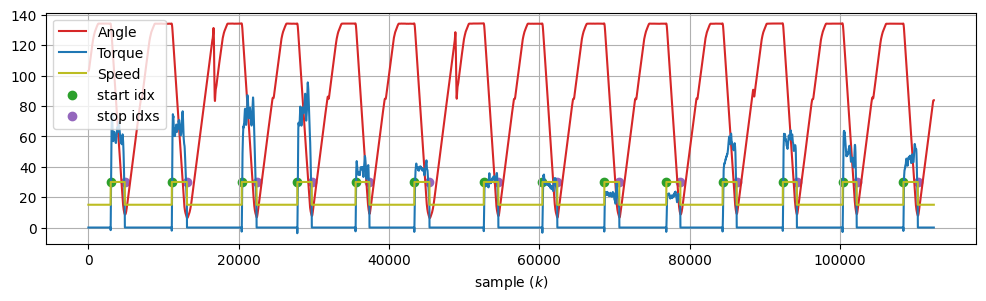

In [6]:
isoforce_iso.plot_data()

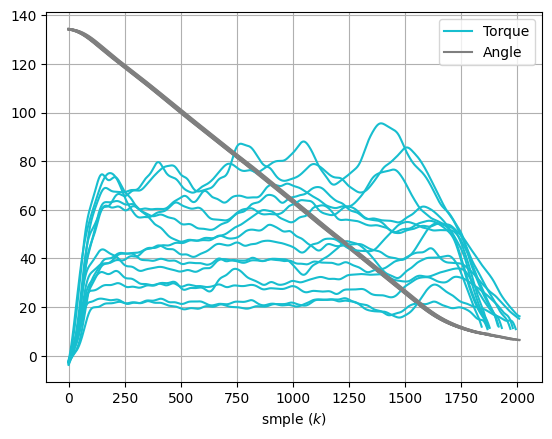

In [7]:
for idx in range(len(isoforce_iso.torque_segments.keys())):
    plt.plot(isoforce_iso.torque_segments[f"T_seg_{idx}"], "C9")
    plt.plot(isoforce_iso.angle_segments[f"A_seg_{idx}"], "C7")
plt.grid()
plt.legend(["Torque", "Angle"])
plt.xlabel("smple ($k$)")
plt.show()

**Isoforce Python raw**

- Ch_1, P = Angle = red (C3) {Factor = 54, Offset = 12}
- Ch_2, T = Torque = blue (C0) {Factor = 150, Offset = 24}
- Ch_3, S = Speed = yellow (C8) {Factor = 108, Offset = -4}

In [8]:
part_path.isoforce_py_raw

'data/serious_data/Final_Measurements/P01/iso_raw/'

In [9]:
from src import IsoforcePy, Protocol

In [10]:
protocol = Protocol(part_path.path)
print(protocol.Participant.leg)

data/serious_data/Final_Measurements/P01/Participant_P01_protocol.json
{'participant': {'Number': 'P01', 'age': '22', 'gender': 'male', 'leg': 'right'}, 'isokinetic_measurement': {'rotation_velocity': '30 °/s', 'force_levels': '[40 40 80 80 70 70 30 30 20 20 60 60 50 50]'}, 'eit_measurement': {'excitation_frequency': 125000, 'burst_count': 0, 'amplitude': '1 mA', 'frame_rate': 40, 'n_el': 16, 'injection_skip': 5}, 'notes': 'Lever Arm:  36.4 cm\n\nforce level was not random , we did again\n70 80 40 30 20 60 50 is correct one'}
right


In [11]:
isoforce_py = IsoforcePy(
    part_path.isoforce_py_raw,
    protocol,
    LP_filter=True,
    over_UTC=False,
    scale_0_1=True,
)

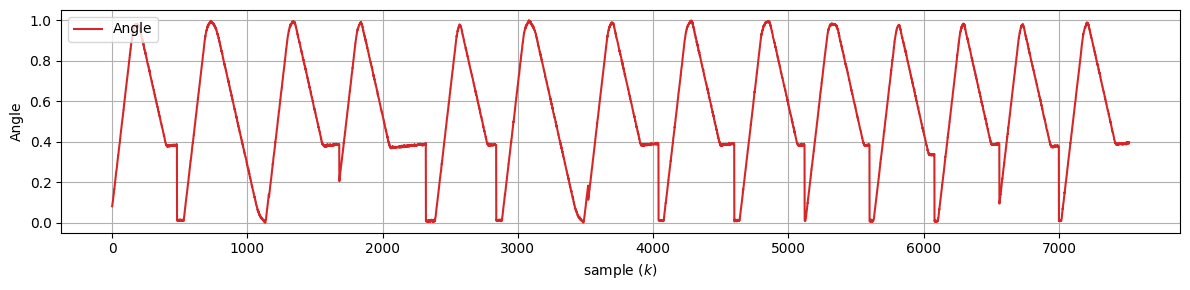

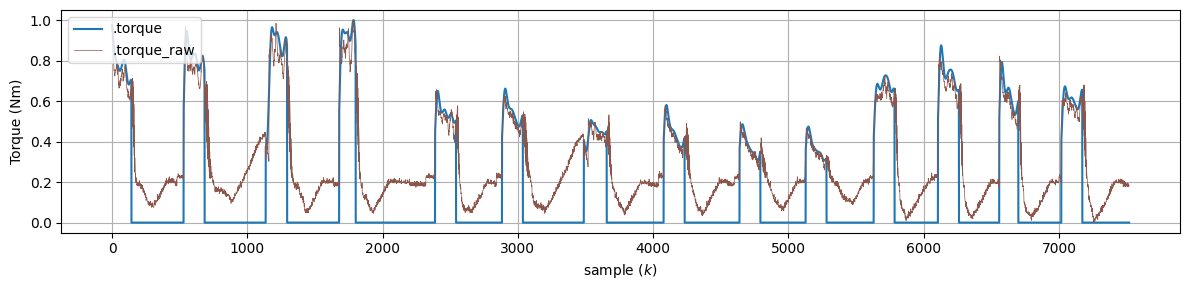

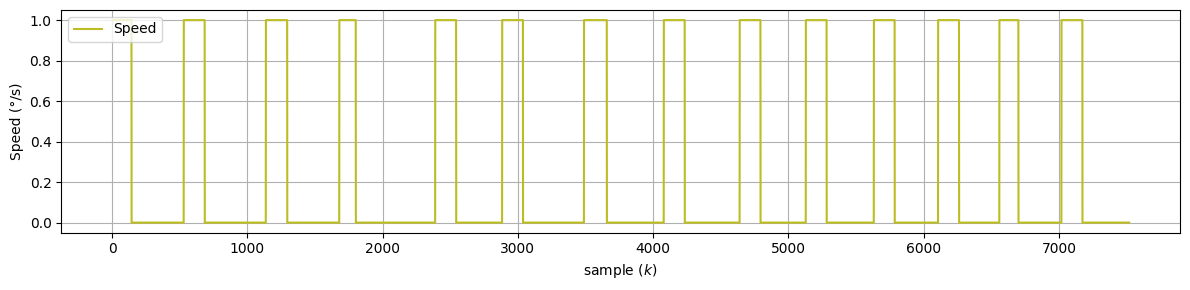

In [12]:
isoforce_py.plot_angle()
isoforce_py.plot_torque()
isoforce_py.plot_speed()

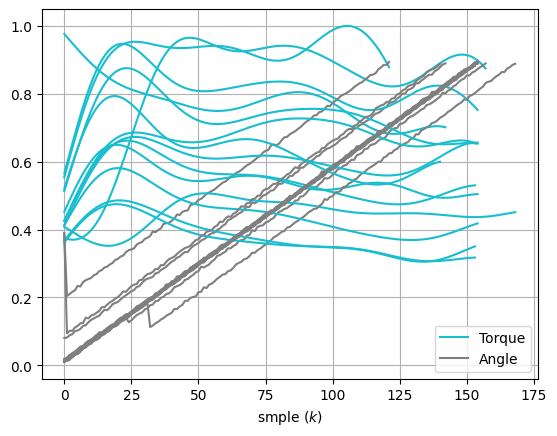

In [17]:
for idx in range(len(isoforce_py.torque_segments.keys())):
    plt.plot(isoforce_py.torque_segments[f"T_seg_{idx}"], "C9")
    plt.plot(isoforce_py.angle_segments[f"A_seg_{idx}"], "C7")
plt.grid()
plt.legend(["Torque", "Angle"])
plt.xlabel("smple ($k$)")
plt.show()

**Sync `isoforce_iso` with `isoforce_py`**

In [18]:
len(isoforce_iso.torque_segments.keys()), len(isoforce_py.torque_segments.keys())

(14, 14)

In [19]:
from scipy.signal import resample


def resample_signals(iso_iso, iso_py, target_length=None):
    iso_iso = np.asarray(iso_iso)
    iso_py = np.asarray(iso_py)
    if target_length:
        print(f"Resample both signals to a length of {target_length} samples.")
        iso_py = resample(iso_py, num=target_length)
        iso_iso = resample(iso_iso, num=target_length)
        return iso_iso, iso_py
    else:
        target_length = max(len(iso_iso), len(iso_py))
        print(f"Resample both signals to a length of {target_length} samples.")
        if len(iso_iso) > len(iso_py):
            iso_py = resample(iso_py, num=target_length)
        elif len(iso_py) > len(iso_iso):
            iso_iso = resample(iso_iso, num=target_length)
        return iso_iso, iso_py


def detect_shift(signal1, signal2):
    N = max(len(signal1), len(signal2))
    corr = np.correlate(signal1, signal2, mode="full")
    lags = np.arange(-N + 1, N)

    max_corr_idx = np.argmax(corr)
    discrete_time_shift = lags[max_corr_idx]
    print(f"Discrete time shift of {discrete_time_shift}.")
    return discrete_time_shift

Resample both signals to a length of 1879 samples.
Discrete time shift of 105.
Resample both signals to a length of 1500 samples.


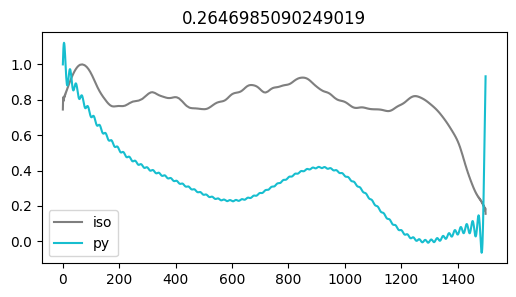

Resample both signals to a length of 2012 samples.
Discrete time shift of -30.
Resample both signals to a length of 1500 samples.


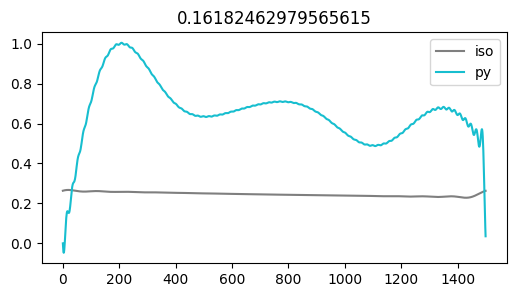

Resample both signals to a length of 1971 samples.
Discrete time shift of -175.
Resample both signals to a length of 1500 samples.


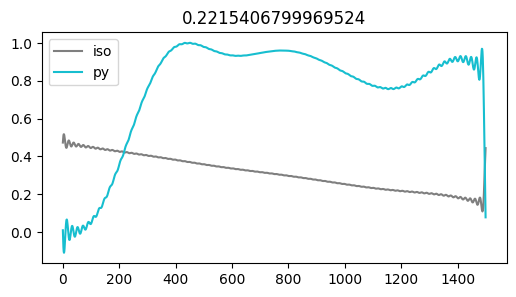

Resample both signals to a length of 1919 samples.
Discrete time shift of -74.
Resample both signals to a length of 1500 samples.


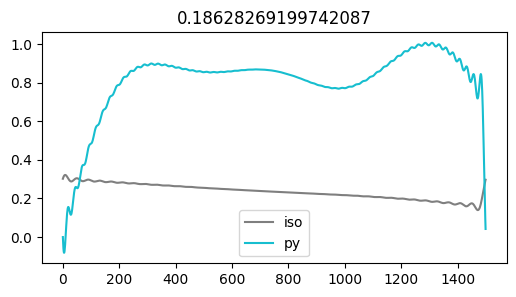

Resample both signals to a length of 1843 samples.
Discrete time shift of 6.
Resample both signals to a length of 1500 samples.


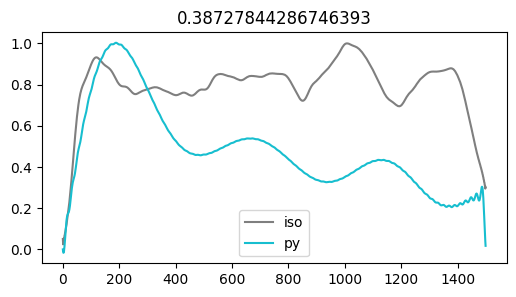

Resample both signals to a length of 2010 samples.
Discrete time shift of 7.
Resample both signals to a length of 1500 samples.


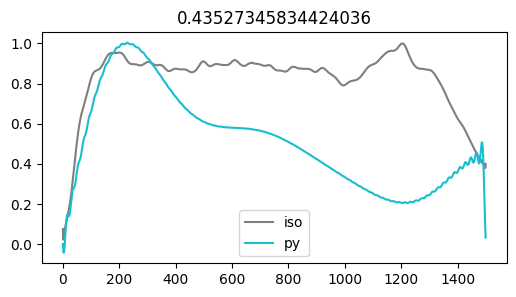

Resample both signals to a length of 1933 samples.
Discrete time shift of -112.
Resample both signals to a length of 1500 samples.


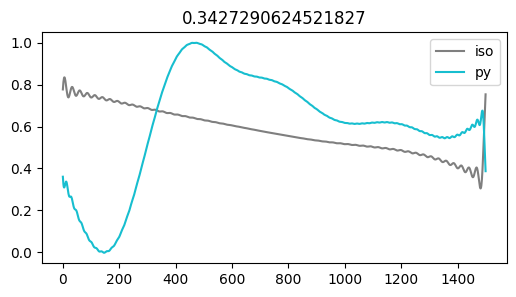

Resample both signals to a length of 1982 samples.
Discrete time shift of 27.
Resample both signals to a length of 1500 samples.


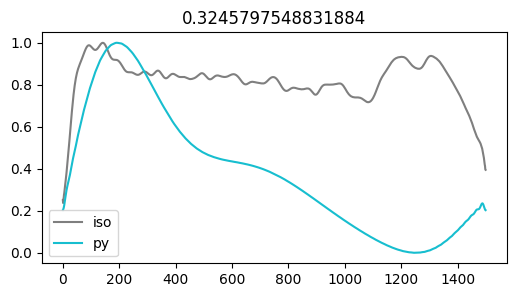

Resample both signals to a length of 1995 samples.
Discrete time shift of 54.
Resample both signals to a length of 1500 samples.


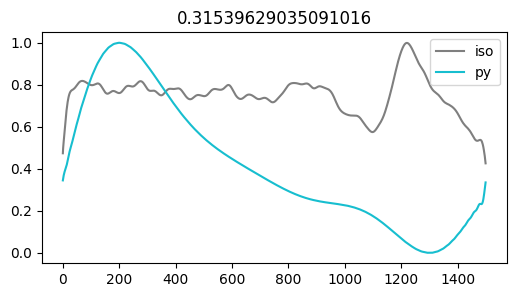

Resample both signals to a length of 1869 samples.
Discrete time shift of 91.
Resample both signals to a length of 1500 samples.


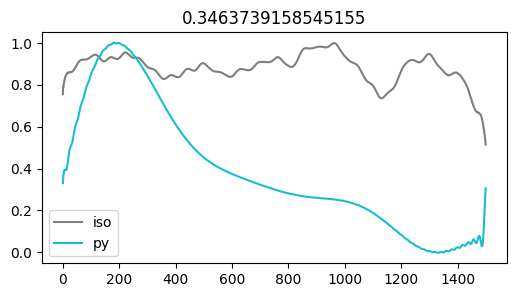

Resample both signals to a length of 1871 samples.
Discrete time shift of -22.
Resample both signals to a length of 1500 samples.


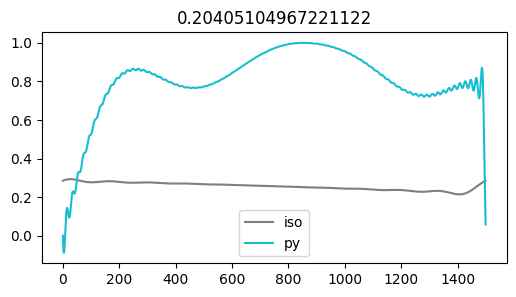

Resample both signals to a length of 1868 samples.
Discrete time shift of 0.
Resample both signals to a length of 1500 samples.


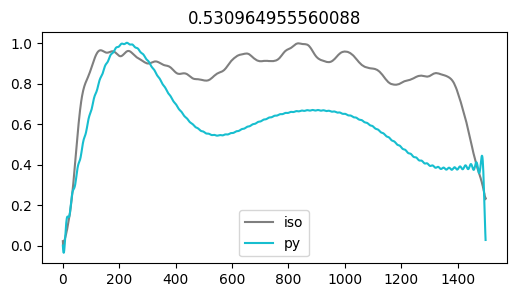

Resample both signals to a length of 1869 samples.
Discrete time shift of 10.
Resample both signals to a length of 1500 samples.


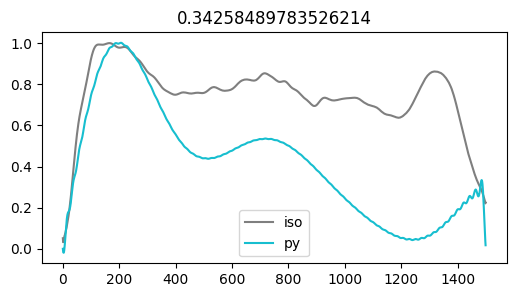

Resample both signals to a length of 1915 samples.
Discrete time shift of -31.
Resample both signals to a length of 1500 samples.


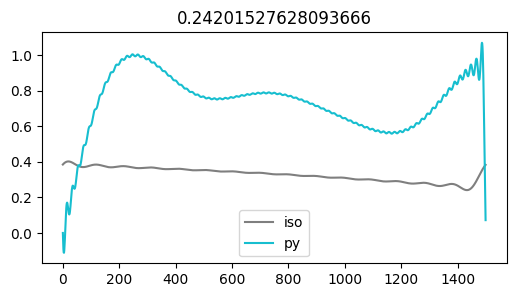

In [20]:
for idx in range(
    min(
        len(isoforce_iso.torque_segments.keys()),
        len(isoforce_py.torque_segments.keys()),
    )
):
    # scale the amplitude rage to [0,1].
    iso_seg = scale_to_range(isoforce_iso.torque_segments[f"T_seg_{idx}"])
    py_seg = scale_to_range(isoforce_py.torque_segments[f"T_seg_{idx}"])
    # create two signals of same length and compute the phase shift.
    iso_seg_corr, py_seg_corr = resample_signals(iso_seg, py_seg)
    shift = detect_shift(iso_seg_corr, py_seg_corr)
    # resample the original, amplitude scaled signals to a constant lenght
    iso_seg, py_seg = resample_signals(iso_seg[shift:], py_seg, target_length=1500)

    plt.figure(figsize=(6, 3))
    plt.title(np.correlate(iso_seg, py_seg)[0] / len(iso_seg))
    # plt.show()
    plt.plot(iso_seg, "C7", label="iso")
    plt.plot(py_seg, "C9", label="py")
    plt.legend()
    plt.show()

In [21]:
for start, stop in zip(isoforce_py.start_idxs, isoforce_py.stop_idxs):
    print("from", isoforce_py.time[start], "to", isoforce_py.time[stop])
    print("Δt", isoforce_py.time[stop] - isoforce_py.time[start])

from 2025-02-18 17:03:06 to 2025-02-18 17:03:09.575000
Δt 0:00:03.575000
from 2025-02-18 17:04:04.225000 to 2025-02-18 17:04:08.100000
Δt 0:00:03.875000
from 2025-02-18 17:04:19.400000 to 2025-02-18 17:05:13.350000
Δt 0:00:53.950000
from 2025-02-18 17:05:22.975000 to 2025-02-18 17:06:08.025000
Δt 0:00:45.050000
from 2025-02-18 17:08:10.700000 to 2025-02-18 17:08:14.575000
Δt 0:00:03.875000
from 2025-02-18 17:09:11.075000 to 2025-02-18 17:09:14.925000
Δt 0:00:03.850000
from 2025-02-18 17:09:26.200000 to 2025-02-18 17:10:15.425000
Δt 0:00:49.225000
from 2025-02-18 17:11:12.950000 to 2025-02-18 17:11:16.825000
Δt 0:00:03.875000
from 2025-02-18 17:12:13.975000 to 2025-02-18 17:12:17.825000
Δt 0:00:03.850000
from 2025-02-18 17:13:07.200000 to 2025-02-18 17:13:11.050000
Δt 0:00:03.850000
from 2025-02-18 17:14:03.775000 to 2025-02-18 17:14:07.625000
Δt 0:00:03.850000
from 2025-02-18 17:14:59.650000 to 2025-02-18 17:15:03.525000
Δt 0:00:03.875000
from 2025-02-18 17:15:10.975000 to 2025-02-18 1

**EIT Sciospec raw**

In [22]:
part_path.print_info()

Fund participant data:

Head directory: self.path='data/serious_data/Final_Measurements/P01/'
Raw Isoforce data measured by Isoforce:
	self.isoforce_iso='data/serious_data/Final_Measurements/P01/EIT_P01_raw_data_12012025114030.txt'
Raw Isoforce data measured by Python:
	self.isoforce_py_raw='data/serious_data/Final_Measurements/P01/iso_raw/'
Raw sciospec EIT data:
	self.sciospec_EIT_raw='data/serious_data/Final_Measurements/P01/eit_raw/'
Raw sciospec EIT samples:
	self.EIT_samples_raw='data/serious_data/Final_Measurements/P01/eit_raw/20250218 17.03.01/setup/'
Preprocessed sciospec EIT samples:
	self.s_path_eit='data/serious_data/Final_Measurements/P01/EIT_processed/'


In [19]:
try:
    os.mkdir(part_path.s_path_eit)
    process_sciospec_eit(part_path)
except BaseException:
    print("Directory already exists.")

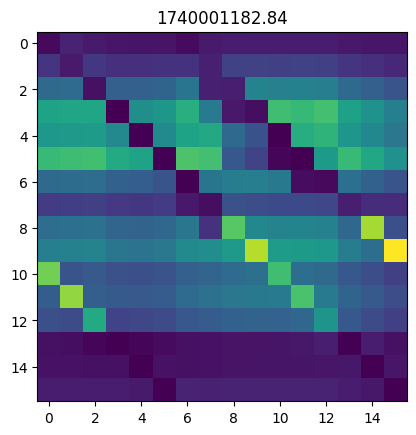

In [20]:
tmp = np.load(part_path.s_path_eit + "setup_00002.npz", allow_pickle=True)
tmp_2 = np.load(part_path.s_path_eit + "setup_00003.npz", allow_pickle=True)
tmp.files

plt.title(tmp["timestamp"])
plt.imshow(np.abs(tmp["eit"]))
plt.show()

In [21]:
times = list()
for ele in np.sort(glob(part_path.s_path_eit + "*.npz")):
    tmp = np.load(ele, allow_pickle=True)
    times.append(tmp["timestamp"])
times = np.array(times)

In [31]:
time_py = isoforce_py.time

In [22]:
time_py = [dt.timestamp() for dt in isoforce_py.time]

AttributeError: 'numpy.int64' object has no attribute 'timestamp'

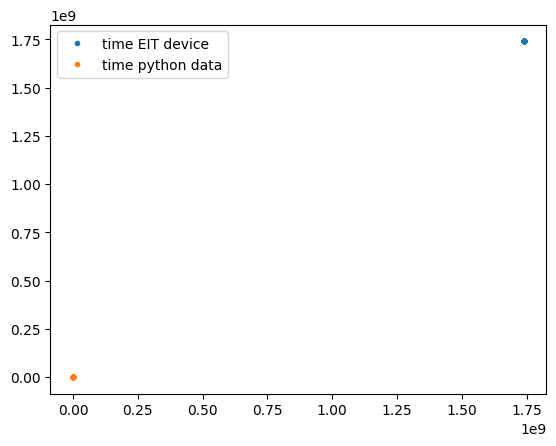

In [32]:
plt.plot(times[::50], times[::50], ".", label="time EIT device")
plt.plot(time_py[::50], time_py[::50], ".", label="time python data")
plt.legend()

In [33]:
print(len(time_py))
print(len(times))

19800
33558


In [25]:
import datetime

dt = datetime.datetime(2025, 1, 13, 9, 24, 5, 130000)
float_timestamp = dt.timestamp()

print(float_timestamp)  # Output: 1736766245.0

1736778245.13


In [26]:
float_timestamp = 1736756645.0003
dt = datetime.datetime.fromtimestamp(float_timestamp)

print(dt)  # Output: 2025-01-13 09:24:05

2025-01-13 03:24:05.000300


In [27]:
datetime.datetime.fromtimestamp(time_py[0])

NameError: name 'time_py' is not defined

In [28]:
datetime.datetime.fromtimestamp(time_py[-1])

NameError: name 'time_py' is not defined

In [ ]:
print(datetime.datetime.fromtimestamp(times[0]))
print(datetime.datetime.fromtimestamp(times[-1]))

**Load eit and color time in PCA**

In [ ]:
EIT = list()
for ele in np.sort(glob(part_path.s_path_eit + "*.npz")):
    tmp = np.load(ele, allow_pickle=True)
    EIT.append(tmp["eit"])
EIT = np.asarray(EIT)
EIT = np.abs(EIT)

In [ ]:
from sklearn.decomposition import PCA

data_flattened = EIT.reshape(EIT.shape[0], -1)
pca = PCA(n_components=2)
data_reduced = pca.fit_transform(data_flattened)

plt.scatter(
    data_reduced[:, 0],
    data_reduced[:, 1],
    c=scale_to_range(times),
    edgecolor="k",
    alpha=0.7,
)
plt.xlabel("1. PC", fontsize=12)
plt.ylabel("2. PC", fontsize=12)
plt.show()